## 141B Lecture 11

## Data Munging


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

One might think that we have everything that we need to work with data.
We can read data with built-in Python functions and we can store and manipulate that data with Numpy.
Numpy is based around the Array, and Pandas is based around the DataFrame.
Unlike the Array, the Dataframe treats each axis differently, with named columns and indexed rows.
Pandas does this under the assumption that a DataFrame holds a large sample of a limited number of variables.
Each column corresponds to a variable, while each row corresponds to an individual, time-point, or other index for repeated data.

Due to this presumption, Pandas is able to optimize operations such as indexing, aggregation, and time series statistics.
It also	has great Input/Output tools for reading delimited data, working with databases, and HDF5 data.	
Pandas is built around the data types: DataFrames, Series.
Roughly, a Series is a list of indices and values (think of a time series where the datatime is the index), and a DataFrame is a dictionary where the keys are the column names and the values are entire Series, and these Series have a common index.
This is a high-level overview of Pandas, and for more syntax details see http://pandas.pydata.org/pandas-docs/stable/

### Series

Let's simulate a Brownian motion so that we can discuss Series objects.  You can see a plot of this below, we will go over data visualization in the next chapter.

In [2]:
T = 1000
innov = np.random.normal(0,1,T)
brown = np.cumsum(innov)

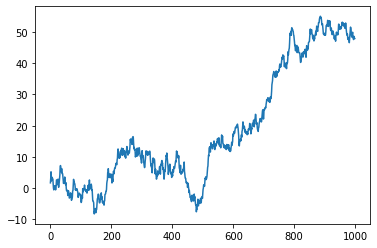

In [3]:
plt.plot(brown)
plt.show()

Let's suppose that the above simulation represents the change in a stock price starting from Jan 1, 2015. Pandas provides a tool for making sequences of datetimes; the following makes a DateTimeIndex object.

In [4]:
days = pd.date_range('1/1/2015',periods=T,freq='d')

We will return to datetime functionality in Pandas later.  Another option for working with datetimes is the ``datetime`` package, which has the date, time, and datetime types and a timedelta object for increments of time.  To see the specifics of the ``datetime`` package you can look at https://docs.python.org/3.7/library/datetime.html  

The resulting list contains the dates, for example,

In [5]:
days[600]

Timestamp('2016-08-23 00:00:00', freq='D')

We can initialize a series with a 1D array and an index sequence.  If you omit the index then it will index with the row number.  You can also initialize with dictionaries where the index values are the keys and the values are the data.

In [6]:
stock = pd.Series(brown,index=days)

The Series object should be thought of as a vector of data where each value is attached to an index value.  Series operations will preserve the indices when they can.  You can slice a series as if it were an array; in the following, we look at every seventh day in the first 100 days.

In [7]:
stock[:100:7]

2015-01-01    1.716015
2015-01-08    2.841195
2015-01-15    0.663130
2015-01-22    2.479183
2015-01-29    1.431195
2015-02-05    5.772854
2015-02-12    2.918406
2015-02-19    1.681542
2015-02-26   -0.906079
2015-03-05   -3.085700
2015-03-12   -3.645269
2015-03-19    1.984616
2015-03-26   -0.647522
2015-04-02   -2.931073
2015-04-09   -2.003976
Freq: 7D, dtype: float64

Due to the indexing, we can also think of this as a dictionary, as in the following.

In [8]:
stock['2016/7/27']

12.782286188070643

One of the key features that makes the series different from an array is that operations between two series will align the indices.  For example, suppose that we have bought 100 shares of another stock on Jan 1, 2016, which we can simulate as well.  As usual, since we are reusing code, let's wrap it up in a function which we could put in a module.

In [9]:
def stock_sim(T,day1):
    """Simulate a stock for T days starting from day1"""
    innov = np.random.normal(0,1,T)
    brown = np.cumsum(innov)
    days = pd.date_range(day1,periods=T,freq='d')
    return pd.Series(brown,index=days)

In [10]:
T = 1000 - 365
day1 = '2016/1/1'
stock_2 = stock_sim(T,day1)

For each date we would like to see the difference between the value of the portfolio and the amount we spent on the portfolio.  This is proportional to the sum of the two changes in stock price since we have bought even amounts of each stock.

In [11]:
portfolio = stock.add(stock_2,fill_value=0)

``stock`` and ``stock_2`` have different lengths but we are able to add them because the indices can be matched.  So after 2016 the change in value of stock 2 is added to stock 1 since that will correspond to the change in portfolio value.  We had to specify a ``fill_value`` of 0 otherwise it would try report the portfolio value as missing before 2016.  We can plot this.

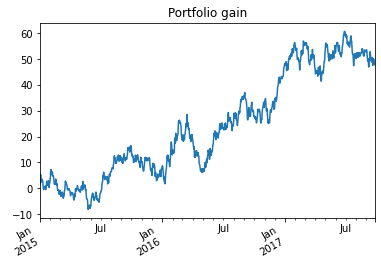

In [12]:
# See next chapter
ax = portfolio.plot(title="Portfolio gain")
ax.figure.autofmt_xdate()
plt.show()

### Dataframe

You should think of a dataframe as a collection of series objects with a common index.
Each series in the dataframe has a different name, and they should be thought of as different variables.  We can initialize the dataframe with a dictionary mapping names to series objects.

In [13]:
port_df = pd.DataFrame({'stock 1':stock,'stock 2':stock_2,'portfolio':portfolio})

If we had passed arrays instead of series then the default index of the row numbers would be used.  You can also pass a 2D array and specify the ``indices`` and ``columns`` arguments.  There are other ways to initialize a dataframe, such as from lists of tuples and lists of dictionaries.

We can view the first few rows of any dataframe with the ``head`` method.

In [14]:
port_df.head()

,stock 1,stock 2,portfolio
2015-01-01,1.716015,NaN,1.716015
2015-01-02,3.134750,NaN,3.134750
2015-01-03,5.238548,NaN,5.238548
2015-01-04,2.308689,NaN,2.308689
2015-01-05,2.872132,NaN,2.872132


We see that stock 2 was filled with NaN values.  We can also get at the indices and names via

In [15]:
print(port_df.index[:7])
print(port_df.columns)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
               '2015-01-05', '2015-01-06', '2015-01-07'],
              dtype='datetime64[ns]', freq='D')
Index(['stock 1', 'stock 2', 'portfolio'], dtype='object')


Accessing elements in a dataframe differs from arrays in the following ways:

- dataframes act like dictionaries from the column names to the column
- slicing is done over the row indices
- to access elements use .loc

In [16]:
port_df['stock 1'].head() # this returns the column

2015-01-01    1.716015
2015-01-02    3.134750
2015-01-03    5.238548
2015-01-04    2.308689
2015-01-05    2.872132
Freq: D, Name: stock 1, dtype: float64

In [17]:
port_df['2015/1/1':'2016/1/1'].head() #this returns a slice of rows

,stock 1,stock 2,portfolio
2015-01-01,1.716015,NaN,1.716015
2015-01-02,3.134750,NaN,3.134750
2015-01-03,5.238548,NaN,5.238548
2015-01-04,2.308689,NaN,2.308689
2015-01-05,2.872132,NaN,2.872132


Boolean fancy indexing works in the place of the slice above as well, for example, we can select rows with a boolean series,

In [18]:
port_df[port_df['portfolio'] > port_df['stock 1']].head()

,stock 1,stock 2,portfolio
2016-01-01,8.560254,0.115453,8.675708
2016-01-12,5.333871,1.038811,6.372683
2016-01-13,6.079132,1.467496,7.546627
2016-01-14,7.780583,1.575427,9.356010
2016-01-15,9.260823,2.253576,11.514399


which will find the elements in which the portfolio is better off than just our share in stock 1.  The comparison between the portfolio and stock 1 is not quite fair because we invested more money in the portfolio.  We can create new columns via the following assignment,

In [19]:
s1sim = port_df['stock 1'].add(port_df['stock 1']['2016/1/1':],fill_value=0)
port_df['stock 1 sim'] = s1sim
port_df[port_df['portfolio'] > port_df['stock 1 sim']].head()

,stock 1,stock 2,portfolio,stock 1 sim
2016-01-25,5.566959,5.897782,11.464741,11.133918
2016-01-26,6.676599,6.783943,13.460542,13.353198
2016-01-27,7.379763,9.461308,16.841070,14.759525
2016-01-28,7.682397,10.216684,17.899081,15.364794
2016-01-29,7.228278,9.295756,16.524034,14.456556


We added the value of stock 1 after 2016 to all of stock 1 to see what the price would be if we invested in stock 1 again on Jan 1, 2016.  If we wanted to select instead a specific date, we would need to use the ``loc`` method, 

In [20]:
port_df.loc['2016/7/27']

stock 1        12.782286
stock 2         9.499296
portfolio      22.281582
stock 1 sim    25.564572
Name: 2016-07-27 00:00:00, dtype: float64

We can select and slice the dataframe as if it were a Numpy array using the ``iloc`` method,

In [21]:
port_df.iloc[400:405,0:3]

,stock 1,stock 2,portfolio
2016-02-05,4.477208,9.228976,13.706185
2016-02-06,3.894809,10.841898,14.736707
2016-02-07,5.923513,13.431442,19.354955
2016-02-08,5.108110,12.278905,17.387016
2016-02-09,5.215039,12.366939,17.581978


Other things to be aware of are 

- the ``info`` method which provides the types and information of the columns,
- many elementwise Numpy operations can be performed on series and dataframes, such as ``np.exp``
- Pandas has many of the same descriptive statistics such as ``dataframe.mean()`` including ``min, max, std, count,...``

We can see many of the descriptive statistics with the ``describe`` method.

In [22]:
port_df.describe()

,stock 1,stock 2,portfolio,stock 1 sim
count,1000.000000,635.000000,1000.000000,1000.000000
mean,18.484721,8.616824,23.956404,35.468818
std,18.981341,5.523930,19.992708,38.639429
min,-8.225786,-2.650435,-8.225786,-15.094475
25%,3.247689,3.761642,6.834605,4.050856
50%,12.334209,9.339304,20.706094,16.935877
75%,37.519264,12.897303,45.580664,75.038528
max,55.002709,21.711928,60.619873,110.005417
